# Customer Churn Prediction

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# If you are using SMOTE
from imblearn.over_sampling import SMOTE

sns.set_style('darkgrid')

#### Data Preparation based on EDA

In [ ]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID"], inplace = True, axis = 1)
    
    df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    df.TotalCharges.fillna(0, inplace = True)
    df.TotalCharges = df.TotalCharges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
    
    return df

In [ ]:
df = datapreparation(filepath="Telco-Customer-Churn.csv")

df.head()

In [ ]:
df.isnull().any().any()

## Model Building

I am going to build and tune random forest model because in this case tree based method would perform better. I am also interested in individual customer's churning probability and in understanding how the model calculates it using Shap values.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=111, stratify = df.Churn)

In [ ]:
x = df.columns[df.columns!="Churn"]
y = "Churn"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]

In [ ]:
#function for model fitting
def churn_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):
    algo.fit(training_x,training_y)
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:,1]
    
    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)
        
    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algo)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,probabilities) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities)
    
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.subplot(212)
    sns.barplot(x = coef_sumry["features"] ,y = coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")
    
    plt.show()

### Hyperparameters Tuning

#### Grid 1: Selecting class weight and estimators

In [ ]:
param_grid1 = {
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [100, 200, 300]   # start small
}

rf_model = RandomForestClassifier(random_state=42)
grid1 = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid1,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)
grid1.fit(train_x, train_y)   # this must finish!


In [ ]:
grid1.best_estimator_

In [ ]:
dt = pd.DataFrame(grid1.cv_results_)
dt.param_max_features = dt.param_max_features.astype(str)
dt.param_n_estimators = dt.param_n_estimators.astype(str)

table = pd.pivot_table(dt, values='mean_test_score', index='param_n_estimators', 
                       columns='param_max_features')
     
sns.heatmap(table)

In [ ]:
grid1.best_score_

#### Grid 2: Selecting max depth and split criterion

In [14]:
param_grid2 = {'max_features':['sqrt'],
          'n_estimators':[1000, 1100, 1200],
           'criterion': ['entropy', 'gini'],    
          'max_depth': [7, 9, 11, 13, 15, None],
         }

rf_model = RandomForestClassifier()
grid2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2.fit(train_x, train_y)

,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ['entropy', 'gini'], 'max_depth': [7, 9, ...], 'max_features': ['sqrt'], 'n_estimators': [1000, 1100, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,1000


In [15]:
grid2.best_estimator_

,n_estimators,1000
,criterion,'gini'
,max_depth,11
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


<Axes: xlabel='param_criterion', ylabel='param_max_depth'>

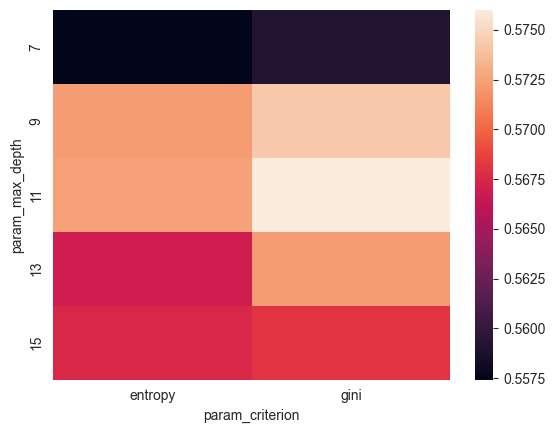

In [16]:
dt = pd.DataFrame(grid2.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_criterion')
     
sns.heatmap(table)

<Axes: xlabel='param_n_estimators', ylabel='param_max_depth'>

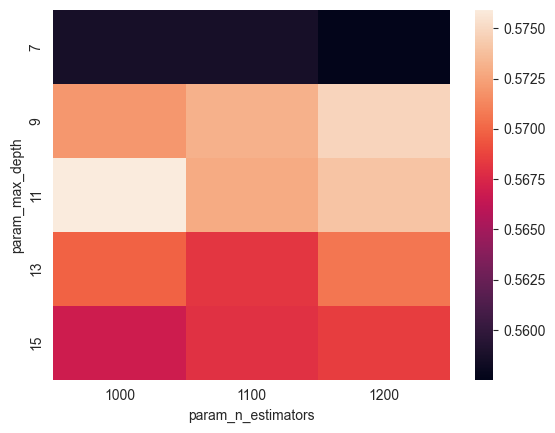

In [17]:
table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_n_estimators')
     
sns.heatmap(table)

In [18]:
grid2.best_score_

np.float64(0.5780276048642885)

Checking if other depth and estimator value results better

In [19]:
param_grid2_2 = {'max_features':['sqrt'],
          'n_estimators':[950, 1000, 1050],
           'criterion': ['entropy'],    
          'max_depth': [10, 11, 12],
         }

rf_model = RandomForestClassifier()
grid2_2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2_2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2_2.fit(train_x, train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ['entropy'], 'max_depth': [10, 11, ...], 'max_features': ['sqrt'], 'n_estimators': [950, 1000, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,950


In [20]:
grid2_2.best_estimator_

,n_estimators,950
,criterion,'entropy'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
grid2_2.best_score_

np.float64(0.5792449707231605)

#### Grid 3: Selecting minimum samples leaf and split

In [22]:
param_grid3 = {'max_features':['sqrt'],
          'n_estimators':[1000],
           'criterion': ['entropy'],    
          'max_depth': [10],
          'min_samples_leaf': [1, 3, 5, 7],
          'min_samples_split': [2, 4, 6, 8]
         }

rf_model = RandomForestClassifier()
grid3 = GridSearchCV(estimator=rf_model, param_grid=param_grid3, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid3.fit(train_x, train_y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ['entropy'], 'max_depth': [10], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 3, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,1000


In [23]:
grid3.best_estimator_

,n_estimators,1000
,criterion,'entropy'
,max_depth,10
,min_samples_split,8
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


<Axes: xlabel='param_min_samples_split', ylabel='param_min_samples_leaf'>

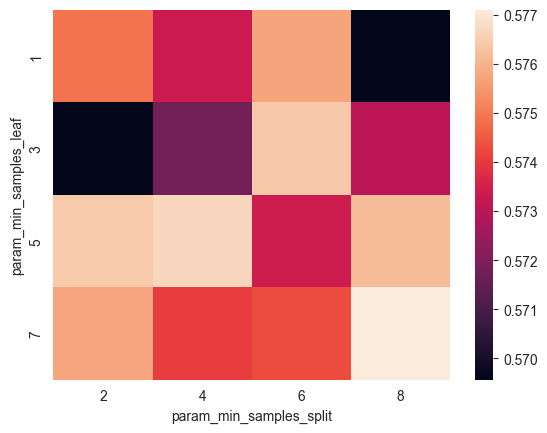

In [24]:
dt = pd.DataFrame(grid3.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_min_samples_leaf', 
                       columns='param_min_samples_split')
     
sns.heatmap(table)

In [25]:
grid3.best_score_

np.float64(0.5770958860958099)

#### Grid 4: Selecting class weight

In [26]:
param_grid4 = {'class_weight':[{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
            'max_features':['sqrt'],
          'n_estimators':[1000],
           'criterion': ['entropy'],    
          'max_depth': [10],
          'min_samples_leaf': [1],
          'min_samples_split': [8]
         }

rf_model = RandomForestClassifier()
grid4 = GridSearchCV(estimator=rf_model, param_grid=param_grid4, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid4.fit(train_x, train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


,estimator,RandomForestClassifier()
,param_grid,"{'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, ...], 'criterion': ['entropy'], 'max_depth': [10], 'max_features': ['sqrt'], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,1000


In [27]:
grid4.best_estimator_

,n_estimators,1000
,criterion,'entropy'
,max_depth,10
,min_samples_split,8
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


<Axes: ylabel='param_class_weight'>

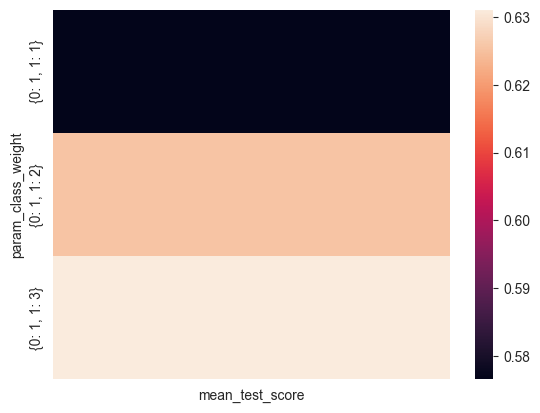

In [28]:
dt = pd.DataFrame(grid4.cv_results_)
dt.param_class_weight = dt.param_class_weight.astype(str)
table = pd.pivot_table(dt, values='mean_test_score', index='param_class_weight')
     
sns.heatmap(table)

In [29]:
grid4.best_score_

np.float64(0.6310725516317821)

### Final Model

In [30]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForestClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
                       max_depth=10, min_samples_split=8, n_estimators=1000)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      1035
           1       0.59      0.66      0.62       374

    accuracy                           0.79      1409
   macro avg       0.73      0.75      0.74      1409
weighted avg       0.80      0.79      0.79      1409

Accuracy   Score :  0.7899219304471257
Area under curve :  0.8477072515435686 



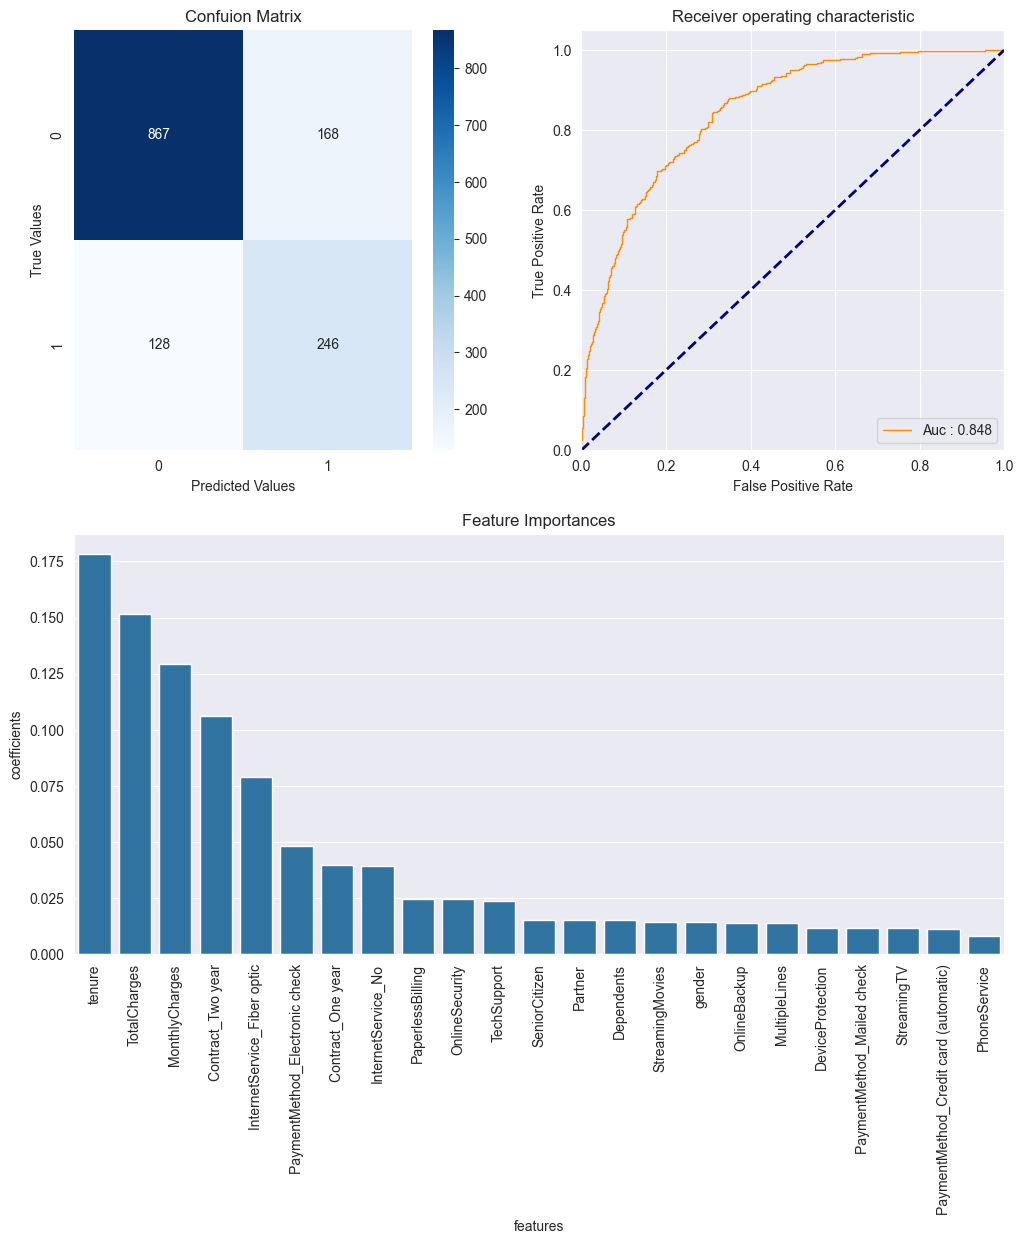

In [31]:
churn_prediction(model, train_x, train_y, test_x, test_y, x,"features")

Checking the model's performance on train data itself

In [32]:
train_scores = cross_val_score(model, train_x, train_y, cv = 5, scoring='f1')
train_scores

array([0.60493827, 0.66453674, 0.61392405, 0.58415842, 0.63836478])

In [33]:
np.mean(train_scores)

np.float64(0.621184451833541)

As we can see that the performance of the model on test data is same as training data. So, we can conclude that there is no overfitting and underfitting.

#### Saving model

In [34]:
import pickle
pickle.dump(model, open('model.pkl','wb'))

## Explaining the model

In [35]:
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, info_plots


c:\Users\Mallesh\Desktop\Customer-Survival-Analysis-and-Churn-Prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
from sklearn.model_selection import train_test_split

# Assuming your preprocessed dataset is in df and the target column is "Churn"
X = df.drop("Churn", axis=1)
y = df["Churn"]

train_x, test_x, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [37]:
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance
import eli5

# Define model
model = RandomForestClassifier(
    n_estimators=300,
    criterion='entropy',
    max_depth=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Train
model.fit(train_x, train_y)

# Permutation importance
perm = PermutationImportance(model, random_state=1).fit(test_x, test_y)

# Show importance
eli5.show_weights(perm, feature_names=test_x.columns.tolist())


Weight,Feature
0.0288 ± 0.0131,tenure
0.0187 ± 0.0151,InternetService_Fiber optic
0.0180 ± 0.0055,TotalCharges
0.0102 ± 0.0087,Contract_Two year
0.0070 ± 0.0064,MonthlyCharges
0.0070 ± 0.0053,Contract_One year
0.0060 ± 0.0029,MultipleLines
0.0058 ± 0.0053,PaperlessBilling
0.0057 ± 0.0062,PaymentMethod_Electronic check
0.0054 ± 0.0037,InternetService_No


Visualizing how the partial dependance plots look for top features

#### Internet Service: Fiber Optic

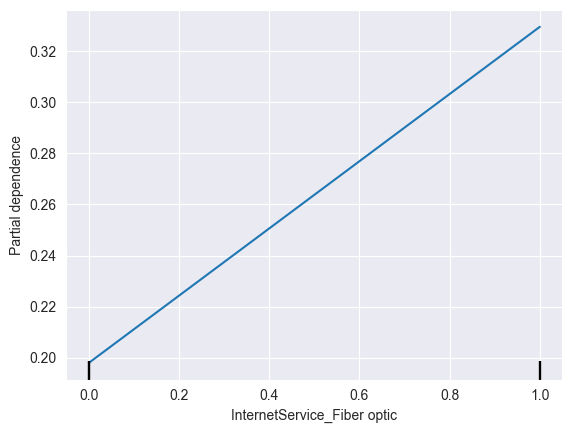

In [38]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Plot partial dependence for the feature
PartialDependenceDisplay.from_estimator(
    model,
    test_x,
    features=['InternetService_Fiber optic'],  # make sure the column exists!
    kind="average"
)

plt.show()



#### Payment Method: Mailed Check

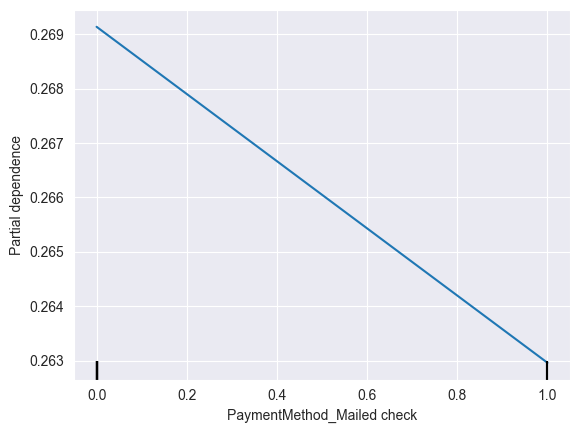

In [39]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Partial dependence for PaymentMethod_Mailed check
PartialDependenceDisplay.from_estimator(
    model,
    test_x,
    features=['PaymentMethod_Mailed check'],  # must match exactly your column name
    kind="average"
)

plt.show()


#### Monthly Charges

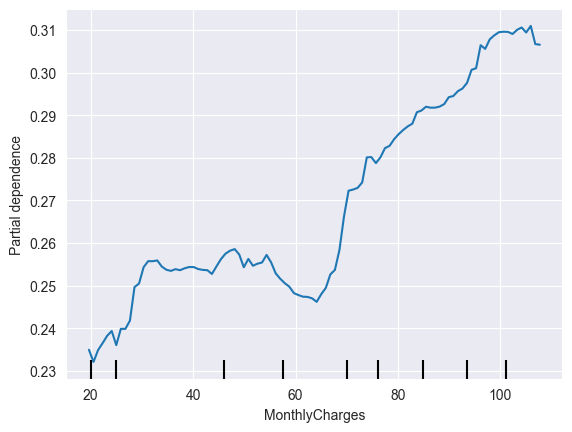

In [40]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Make sure model is trained before this
PartialDependenceDisplay.from_estimator(
    model,
    test_x,
    features=['MonthlyCharges'],
    kind="average"
)

plt.show()


#### Total Charges

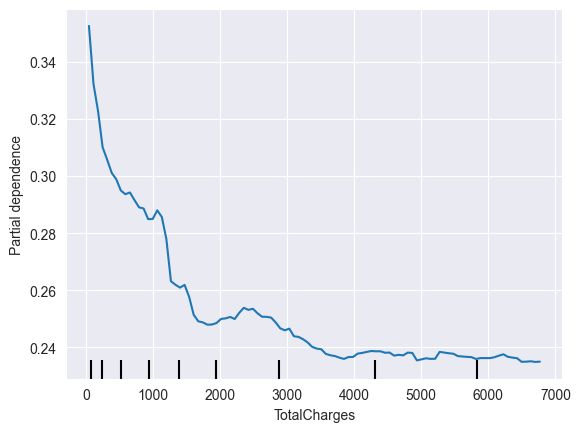

In [41]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Make sure your model is trained already
PartialDependenceDisplay.from_estimator(
    model,
    test_x,
    features=['TotalCharges'],
    kind="average"
)

plt.show()


#### Contract - Two years

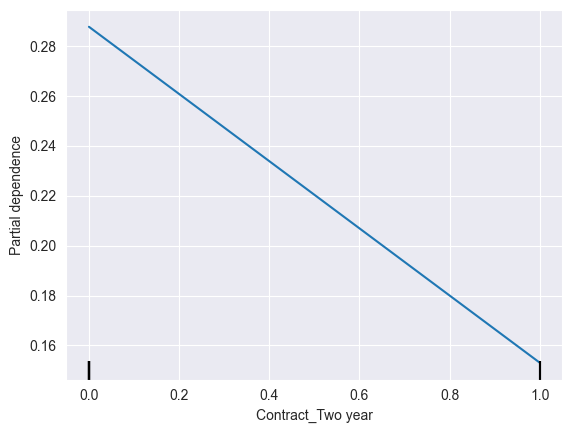

In [42]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# PDP for Contract_Two year
PartialDependenceDisplay.from_estimator(
    model,
    test_x,
    features=['Contract_Two year'],   # make sure this column exists!
    kind="average"
)

plt.show()


#### Tenure

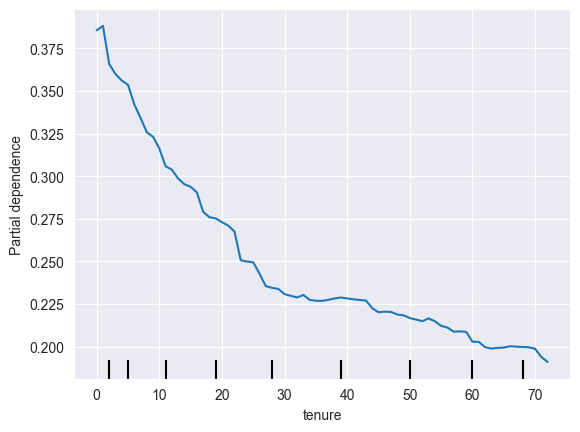

In [43]:
# pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, 
  #                      feature='tenure')
#pdp.pdp_plot(pdp_p, 'tenure')
#plt.show()
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# PDP for tenure
PartialDependenceDisplay.from_estimator(
    model,
    test_x,
    features=['tenure'],
    kind="average"
)

plt.show()


### Shap Values

In [44]:
import shap 
shap.initjs()

import joblib

In [45]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Initialize JS for notebook (optional)
shap.initjs()

# Create TreeExplainer
explainer = shap.TreeExplainer(model)

# Take the first row as DataFrame (keep 2D)
row = test_x.iloc[[0]]

# Get SHAP values (returns Explanation object)
shap_values = explainer(row)


In [46]:
# Saving Explainer
ex_filename = 'explainer.bz2'
joblib.dump(explainer, filename=ex_filename, compress=('bz2', 9))

['explainer.bz2']

In [47]:
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np

# Load the old explainer
explainer = joblib.load("explainer.bz2")

# Take a single row as 1D array
row = np.array(test_x.iloc[0])

# Get SHAP values (old API)
shap_values = explainer.shap_values(row)  # shape (23,2) for binary classifier

# Select class 1 SHAP values (1D array)
shap_values_class1 = shap_values[:, 1]

# Base value for class 1
base_value_class1 = explainer.expected_value[1]

# Plot and save
plt.figure(figsize=(12, 3))
shap.force_plot(
    base_value_class1,
    shap_values_class1,
    features=row,
    feature_names=list(test_x.columns),
    matplotlib=True,
    show=False
)
plt.savefig('static/images/shap.png', bbox_inches='tight')
plt.close()


<Figure size 1200x300 with 0 Axes>

### Gauge Chart 

In [48]:
from matplotlib.patches import Circle, Wedge, Rectangle

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['LOW','MEDIUM','HIGH','EXTREME'], \
          colors=['#007A00','#0063BF','#FFCC00','#ED1C24'], Probability=1, fname=False): 
    
    N = len(labels)
    colors = colors[::-1]

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(4)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, 'Churn Probability ' + np.round(Probability,2).astype(str), horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = (1-Probability)*180
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

In [49]:
gauge(Probability=model.predict_proba(test_x.iloc[0:1])[0,1])

Final Features

In [50]:
test_x.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [51]:
import pickle

# Take the best model from GridSearchCV
best_model = grid4.best_estimator_

# Save it in the project root as model.pkl
with open("model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("✅ model.pkl file saved in project folder")


✅ model.pkl file saved in project folder
